In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


def clustering_process(
    df: pd.DataFrame,
    cluster_method: type[DBSCAN | KMeans],
    scaler_method: type[StandardScaler],
    main_data_columns: list[str] = ["price", "squareMeters", "cityCode"], 
    additional_data_columns: list[str] = ["id"],
    cluster_setup: dict[str, str] = {},
    scaler_setup: dict[str, str] = {}
) -> pd.DataFrame: 
    scaler = scaler_method(**scaler_setup)
    nums = df.loc[:, main_data_columns]
    ids = df.loc[:, additional_data_columns]
    norm_nums = scaler.fit_transform(nums)
    norm = np.column_stack((ids, norm_nums))

    dbscan = cluster_method(**cluster_setup)
    clusters = dbscan.fit_predict(norm_nums)

    processed_df = pd.DataFrame(
        columns=additional_data_columns + main_data_columns + ["cluster_id"])
    i = 0
    for cluster_id in np.unique(clusters):
        cluster_mask = (clusters == cluster_id)
        cluster_data = norm[cluster_mask]
        for data in cluster_data:
            processed_df.loc[i] = list(data) + [cluster_id]
            i += 1

    return processed_df


def cluster_visualize(
    df: pd.DataFrame, 
    x_column: str = "price", 
    y_column: str = "squareMeters", 
    figsize: tuple[int, int] = (10, 10),
    xlabel = "Розмір у м^2",
    ylabel = "Ціна у $",
    title = "Порівняння нерухомості ціна/розмір"
):
    fig, ax = plt.subplots(figsize=figsize)

    for cluster_id in df["cluster_id"].unique():
        cluster_df = df[df["cluster_id"] == cluster_id]
        sct = ax.scatter(cluster_df[x_column], cluster_df[y_column], cmap="viridis", edgecolors="black")
        sct.set_label(f"Cluster: {cluster_id}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.set_cmap('coolwarm')
    fig.legend(ncols=5)
    
    return fig, ax

In [13]:
train_df = pd.read_csv("datasets/paris_housing_price/train.csv")
test_df = pd.read_csv("datasets/paris_housing_price/test.csv")

/tmp/ipykernel_21662/4279635351.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(cluster_df[x_column], cluster_df[y_column], cmap="viridis", edgecolors="black")


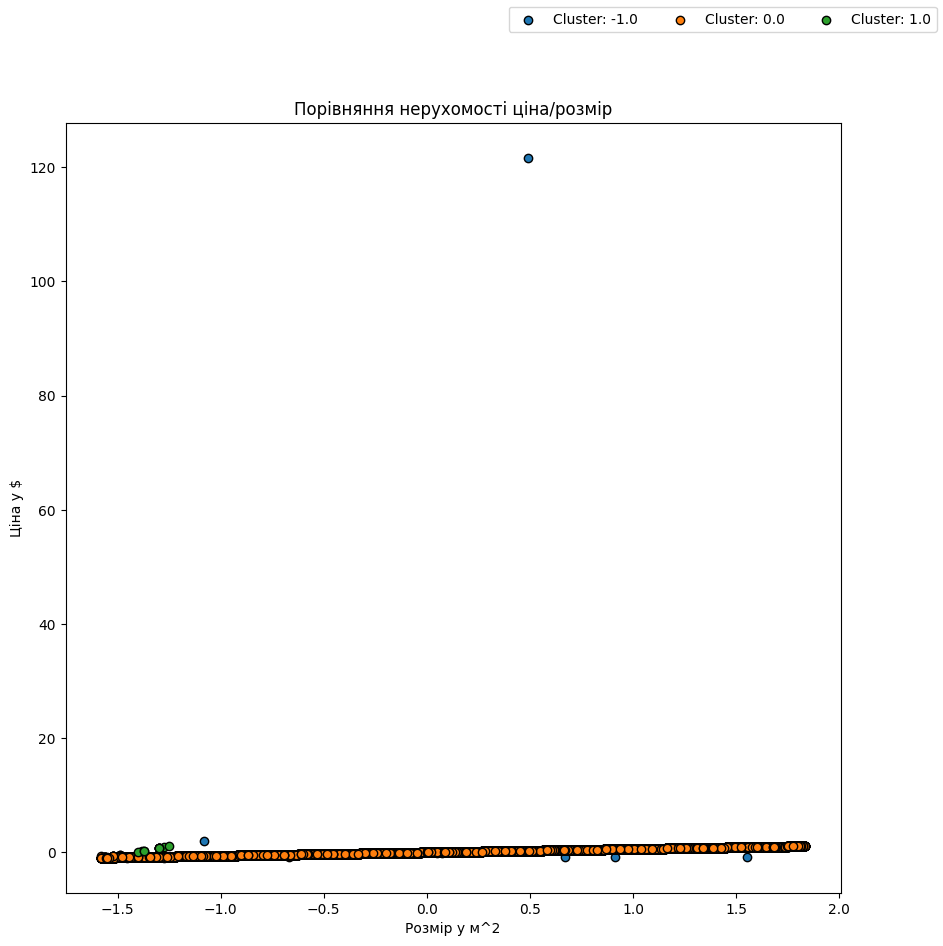

In [14]:
processed_df = clustering_process(train_df, DBSCAN, StandardScaler, main_data_columns=["price", "squareMeters"])
fig, ax = cluster_visualize(processed_df)
plt.show()

/tmp/ipykernel_21662/4279635351.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(cluster_df[x_column], cluster_df[y_column], cmap="viridis", edgecolors="black")


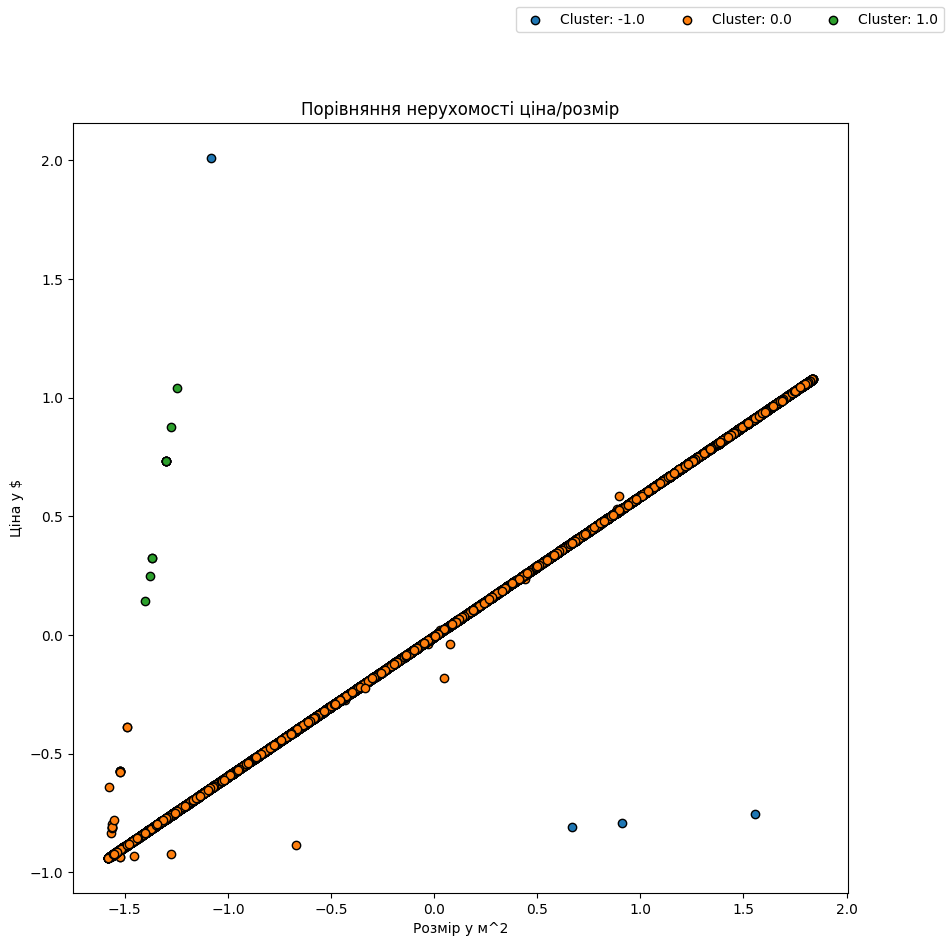

In [16]:
filtered_df = processed_df[processed_df["squareMeters"] < processed_df["squareMeters"].max() * 0.75]
# processed_df = clustering_process(filtered_df, DBSCAN, StandardScaler, main_data_columns=["price", "squareMeters"])
fig, ax = cluster_visualize(filtered_df)
plt.show()

In [2]:
crimes_df = pd.read_csv("datasets/boston_crimes/crime.csv", encoding="windows-1252", on_bad_lines="warn")
crimes_df = crimes_df.fillna(0)
crimes_df["SHOOTING"] = crimes_df["SHOOTING"].replace("Y", 1)
crimes_df["REPORTING_AREA"] = crimes_df["REPORTING_AREA"].replace(" ", 0)


/tmp/ipykernel_5151/572726293.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  crimes_df["SHOOTING"] = crimes_df["SHOOTING"].replace("Y", 1)


/tmp/ipykernel_21662/4279635351.py:52: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(cluster_df[x_column], cluster_df[y_column], cmap="viridis", edgecolors="black")


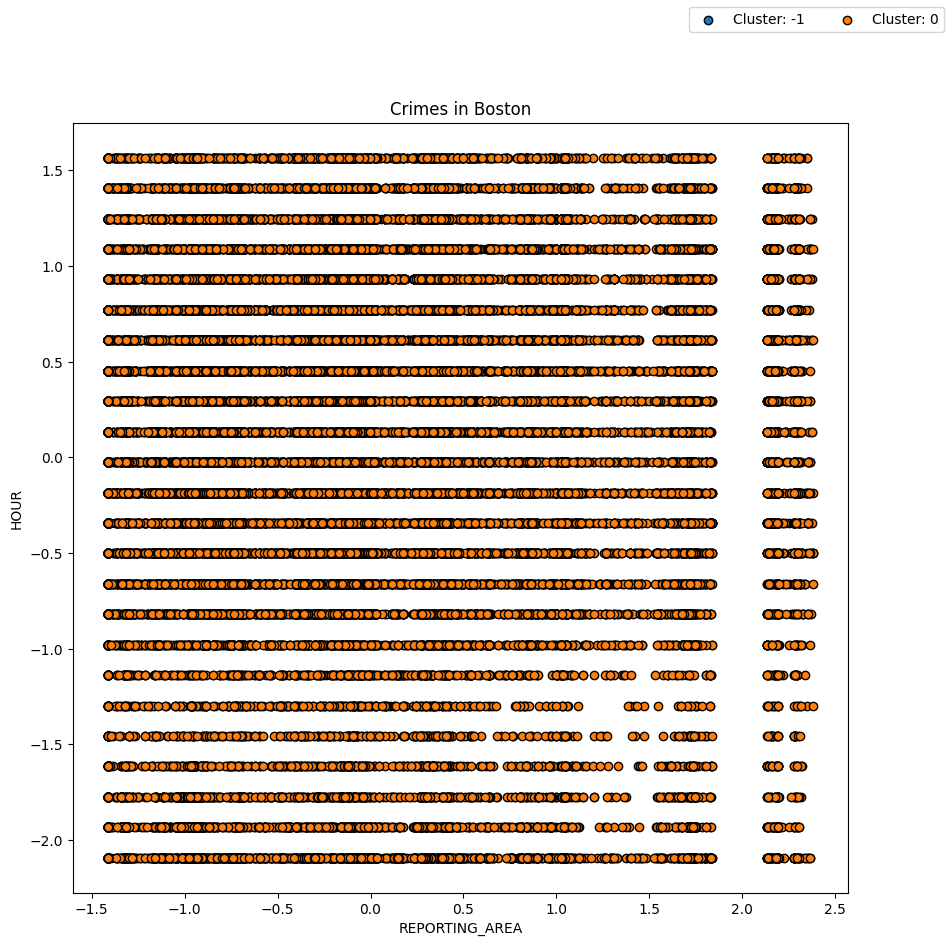

In [6]:
crimes_processed_df = clustering_process(
    crimes_df.iloc[::10, :], 
    DBSCAN, 
    StandardScaler, 
    main_data_columns=["HOUR", "SHOOTING", "REPORTING_AREA"],
    additional_data_columns=["INCIDENT_NUMBER", "Lat", "Long"],
    cluster_setup={"min_samples": 50, "eps": 0.7}
)
fig, ax = cluster_visualize(
    crimes_processed_df, 
    "REPORTING_AREA", 
    "HOUR", 
    xlabel="REPORTING_AREA", 
    ylabel="HOUR", 
    title="Crimes in Boston"
)
plt.show()

In [7]:
ids0 = crimes_processed_df[crimes_processed_df["cluster_id"] == -1]["INCIDENT_NUMBER"]

with pd.option_context("display.max_rows", None):
    cluster_df = crimes_df[crimes_df["INCIDENT_NUMBER"].isin(ids0.values)]
    print("Length in cluster -1: ", len(cluster_df))
    cluster_df = crimes_df[
        (crimes_df["INCIDENT_NUMBER"].isin(ids0.values)) & 
        (crimes_df["SHOOTING"] == 1)
    ]
    print("Length in cluster -1 and shooting 1: ", len(cluster_df))


Length in cluster -1:  252
Length in cluster -1 and shooting 1:  252


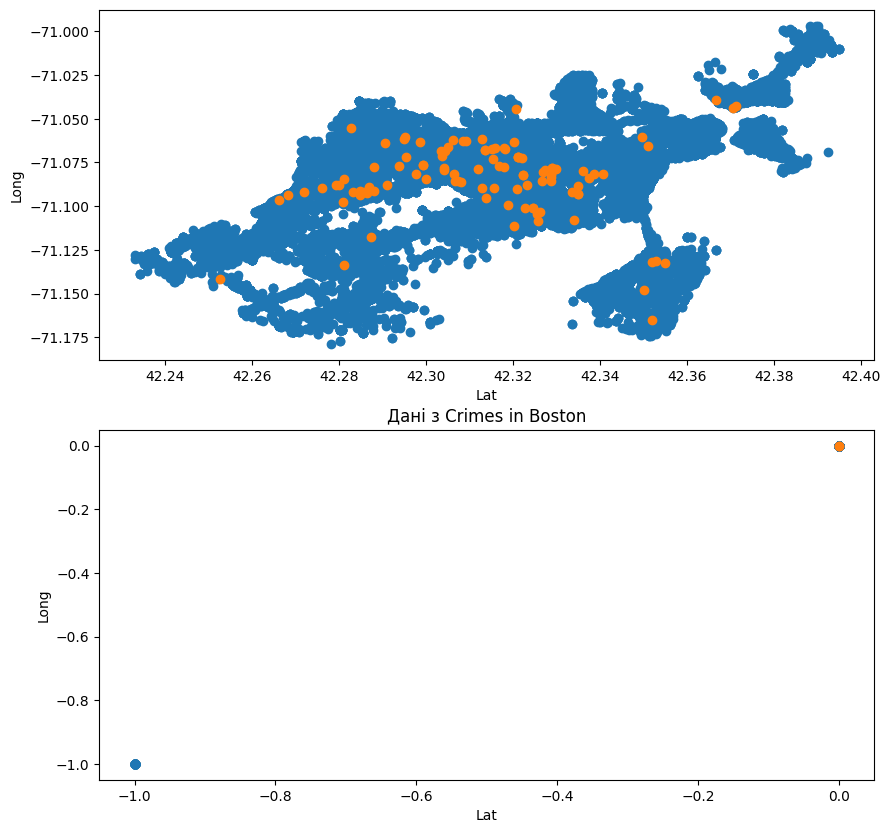

In [12]:
crimes_df1 = crimes_processed_df[crimes_processed_df["Long"] < -5]
crimes_df2 = crimes_processed_df[crimes_processed_df["Long"] >= -5]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.scatter(
    crimes_df1[crimes_df1["cluster_id"] == 0]["Lat"], 
    crimes_df1[crimes_df1["cluster_id"] == 0]["Long"],
)
ax1.scatter(
    crimes_df1[crimes_df1["cluster_id"] == -1]["Lat"], 
    crimes_df1[crimes_df1["cluster_id"] == -1]["Long"], 
)
ax1.set_xlabel("Lat")
ax1.set_ylabel("Long")

ax2.scatter(
    crimes_df2[crimes_df2["cluster_id"] == 0]["Lat"], 
    crimes_df2[crimes_df2["cluster_id"] == 0]["Long"],
)
ax2.scatter(
    crimes_df2[crimes_df2["cluster_id"] == -1]["Lat"], 
    crimes_df2[crimes_df2["cluster_id"] == -1]["Long"], 
)
ax2.set_xlabel("Lat")
ax2.set_ylabel("Long")

plt.title("Дані з Crimes in Boston")
plt.show()

In [7]:
crimes_processed_df = clustering_process(
    crimes_df.iloc[::20, :], 
    DBSCAN, 
    StandardScaler, 
    main_data_columns=["Lat", "Long"],
    additional_data_columns=["INCIDENT_NUMBER"],
    cluster_setup={"min_samples": 50, "eps": 0.7}
)

[0 1]


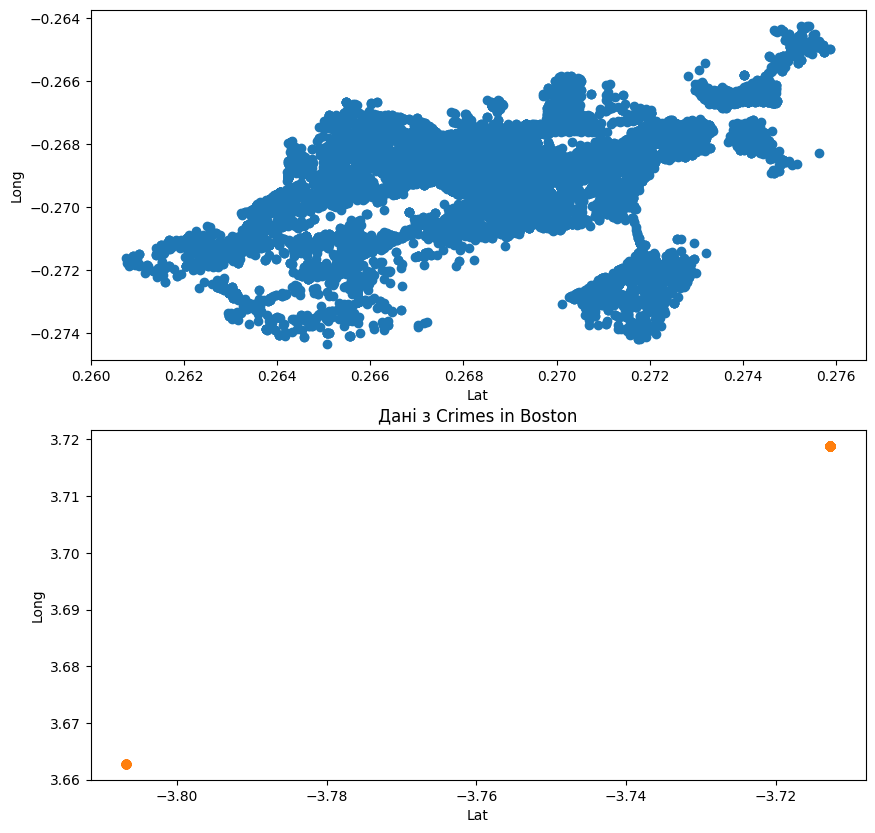

In [6]:

mean = crimes_processed_df["Long"].mean()
crimes_df1 = crimes_processed_df[crimes_processed_df["Long"] < mean]
crimes_df2 = crimes_processed_df[crimes_processed_df["Long"] >= mean]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.scatter(
    crimes_df1[crimes_df1["cluster_id"] == 0]["Lat"], 
    crimes_df1[crimes_df1["cluster_id"] == 0]["Long"],
)
ax1.scatter(
    crimes_df1[crimes_df1["cluster_id"] == 1]["Lat"], 
    crimes_df1[crimes_df1["cluster_id"] == 1]["Long"], 
)
ax1.set_xlabel("Lat")
ax1.set_ylabel("Long")

ax2.scatter(
    crimes_df2[crimes_df2["cluster_id"] == 0]["Lat"], 
    crimes_df2[crimes_df2["cluster_id"] == 0]["Long"],
)
ax2.scatter(
    crimes_df2[crimes_df2["cluster_id"] == 1]["Lat"], 
    crimes_df2[crimes_df2["cluster_id"] == 1]["Long"], 
)
ax2.set_xlabel("Lat")
ax2.set_ylabel("Long")

print(crimes_processed_df["cluster_id"].unique())

plt.title("Дані з Crimes in Boston")
plt.show()